# Adaptive Component Separation with K-means Clustering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-compsep-paper/blob/main/notebooks/kmeans_2.ipynb)

## Learning Objectives

By the end of this notebook, you will:
- Understand adaptive sky clustering for spatially-varying spectral parameters
- Implement spherical K-means clustering for CMB component separation
- Optimize parameters within each cluster using variance-based selection
- Visualize how spatial parameter variation improves foreground modeling

## The Adaptive Clustering Approach

Traditional component separation assumes uniform spectral parameters across the entire sky. In reality, Galactic emissions vary spatially. Our approach uses spherical K-means clustering to partition the sky into regions, allowing different spectral parameters in each cluster.

**Key Innovation**: Minimize CMB reconstruction variance by adaptively clustering sky pixels and optimizing spectral parameters per cluster.

In [1]:
# Setup and Data Loading


# Core libraries
# Data utilities
import operator
from functools import partial

import healpy as hp

# JAX ecosystem
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401

# FURAX framework
from furax.obs import negative_log_likelihood, sky_signal
from furax.obs.stokes import Stokes
from furax_cs import generate_noise_operator, kmeans_clusters
from furax_cs.data import (
    get_instrument,
    get_mask,
    load_cmb_map,
    load_fg_map,
    load_from_cache,
    save_to_cache,
)
from furax_cs.optim import minimize

# JAX-HEALPix for clustering and sky operations
from jax_healpy.clustering import (
    get_cutout_from_mask,
    get_fullmap_from_cutout,
)

W0123 19:31:12.905012   61967 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0123 19:31:12.909332   61841 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
# Configure JAX
jax.config.update("jax_enable_x64", True)

# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2
noise_id = 0
noise_ratio = 1.0
tag = "c1d0s0"
mask_name = "ALL-GALACTIC"

In [3]:
# Generate and load multi-frequency data
save_to_cache(nside, sky=tag)
nu, freq_maps = load_from_cache(nside, sky=tag)
_, fg_maps = load_fg_map(nside, sky=tag)
cmb_map = load_cmb_map(nside, sky=tag)

print(f"Frequency maps shape: {freq_maps.shape}")
print(f"Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX format (Q,U polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])
fg_stokes = Stokes.from_stokes(fg_maps[:, 1], fg_maps[:, 2])
cmb_map_stokes = Stokes.from_stokes(cmb_map[1], cmb_map[2])

# Load galactic mask (cleanest 20% of sky)
mask = get_mask(mask_name, nside=nside)
(indices,) = jnp.where(mask == 1)
coverage = jnp.mean(mask) * 100
print(f"Sky coverage: {coverage:.1f}% ({len(indices):,} pixels)")

# Extract masked data for computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
masked_fg = get_cutout_from_mask(fg_stokes, indices, axis=1)
masked_cmb = get_cutout_from_mask(cmb_map_stokes, indices)
print(f"Masked data shape: {masked_d.shape}")

[INFO] Loaded freq_maps for nside 64 from cache with noise_ratio 0.0.
[INFO] Loaded freq_maps for nside 64 from cache.
[INFO] Loaded freq_maps for nside 64 from cache.
[INFO] Loaded freq_maps for nside 64 from cache.
Frequency maps shape: (15, 3, 49152)
Frequencies: 15 bands from 40 to 402 GHz
Sky coverage: 59.0% (29,009 pixels)
Masked data shape: (15, 29009)


## Step 2: Spherical K-means Clustering

K-means clustering partitions the sky into regions with similar properties. For CMB component separation, we cluster pixels to allow different spectral parameters in each region.

### Why Spherical K-means?
- Sky pixels are distributed on a sphere, not a flat plane
- Standard K-means would distort distances near poles
- Spherical K-means uses angular distance (great-circle distance)

### Cluster Configuration
Each spectral parameter can have a different number of clusters:
- **Dust temperature**: Varies slowly → fewer clusters needed
- **Dust spectral index**: More spatial variation → more clusters
- **Synchrotron index**: Varies slowly → fewer clusters

## Step 3: Noise Model Setup

Real CMB observations contain instrumental noise. We model this as:
- **White noise**: Uncorrelated between pixels and frequencies
- **Noise variance**: Determined by instrument sensitivity

The noise covariance operator `N` is diagonal (independent noise per pixel/frequency).

## Step 4: Parameter Optimization

We minimize the negative log-likelihood to find optimal spectral parameters for each cluster.

### The Likelihood Function
The marginalized likelihood integrates over component amplitudes:
$$\mathcal{L}(\beta) = (A^T N^{-1} d)^T (A^T N^{-1} A)^{-1} (A^T N^{-1} d)$$

### Optimization Strategy
- **Solver**: L-BFGS with zoom linesearch for fast convergence
- **Bounds**: Physical constraints on parameters (e.g., positive temperature)
- **Analytical gradients**: More stable than autodiff for this problem

## Step 5: Parameter Map Reconstruction

After optimization, we map the per-cluster parameters back to the full sky:
1. Each pixel belongs to a cluster
2. The cluster's optimized parameter value is assigned to all its pixels
3. Masked regions remain as `UNSEEN`

In [4]:
# Spherical K-means Clustering
# Configure clustering parameters for different spectral indices
cluster_config = {
    "temp_dust": 500,  # Dust temperature clusters
    "beta_dust": 1500,  # Dust spectral index clusters
    "beta_pl": 500,  # Synchrotron spectral index clusters
}
cluster_config = jax.tree.map(lambda x: min(indices.size, x), cluster_config)

# Generate clusters for each parameter type
print("Generating spherical K-means clusters...")
clusters = {}

# Generate spherical K-means clusters on unmasked pixels
cluster_map = kmeans_clusters(
    jax.random.PRNGKey(42),  # Fixed seed for reproducibility
    mask,
    indices,
    cluster_config,
    initial_sample_size=1,
)

cluster_map = {f"{param}_patches": patches for param, patches in cluster_map.items()}

print("Clustering complete!")

# Visualize the clustering results
fig = plt.figure(figsize=(15, 5))

param_labels = ["Dust Temperature", "Dust Spectral Index", "Synchrotron Index"]
for i, (param, label) in enumerate(zip(cluster_config.keys(), param_labels)):
    cluster_data = cluster_map[f"{param}_patches"]
    n_unique = jnp.unique(cluster_data[cluster_data != hp.UNSEEN]).size

    hp.mollview(
        cluster_data,
        title=f"{label}\n({n_unique} clusters)",
        sub=(1, 3, i + 1),
        bgcolor=(0.0,) * 4,
    )

plt.tight_layout()
plt.show()

# Extract masked clusters for optimization
masked_clusters = get_cutout_from_mask(cluster_map, indices)
masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int64), masked_clusters)
print("Masked clusters ready for optimization")

Generating spherical K-means clusters...
Clustering complete!


TypeError: bad number of pixels

<Figure size 1500x500 with 0 Axes>

## Step 6: Results Visualization

The recovered parameter maps show spatial variation in foreground properties:
- **Dust temperature**: ~20K in most regions
- **Dust spectral index**: ~1.5 with spatial variation
- **Synchrotron index**: ~-3.0 with gradients

## Step 7: Optimization Verification

To verify the optimizer found a true minimum, we perturb the solution and check:
1. **NLL increases** when moving away from the solution
2. **Gradient norms** are minimized at the solution

This confirms the optimization converged correctly.

In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np


class StaticLookupModule(eqx.Module):
    # 1. Define the dynamic parameters (trainable weights, biases, etc.)
    weight: jax.Array

    # 2. Define the static data using eqx.field(static=True)
    lookup_table: np.ndarray = eqx.field(static=True, converter=np.asarray)

    def __init__(self, key, lookup_table):
        # Initialize dynamic weights
        self.weight = jax.random.normal(key, (3,))

        # Initialize the static numpy array
        # This data will be "baked into" the compiled function
        self.lookup_table = lookup_table

    def __call__(self, x):
        # JAX will automatically convert the static numpy array to a
        # constant JAX array during JIT compilation/execution.

        # Example: Scale input by weight and add value from lookup table
        print("Lookup table (static):", self.lookup_table)
        return (x * self.weight) + self.lookup_table


# --- Usage ---

# Initialize
key = jax.random.PRNGKey(0)
module = StaticLookupModule(key)

# Input data
x = jnp.array([1.0, 1.0, 1.0])

# Run normally
output = module(x)
print("Output:", output)

# Run with JIT
# Because lookup_table is static, JAX handles it correctly without errors
jitted_module = eqx.filter_jit(module)
output_jit = jitted_module(x)
print("JIT Output:", output_jit)

Lookup table (static): [10. 20. 30.]
Output: [ 9.79415786 19.21523422 31.81608667]
Lookup table (static): [10. 20. 30.]
JIT Output: [ 9.79415786 19.21523422 31.81608667]


/tmp/ipykernel_61841/1731510800.py:33: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  module = StaticLookupModule(key)


In [11]:
StaticLookupModule(x).lookup_table

TypeError: JAX encountered invalid PRNG key data: expected key_data.shape to end with (2,); got shape=(3,) for impl=PRNGImpl(key_shape=(2,), seed=<function threefry_seed at 0x7ac565d563e0>, split=<function threefry_split at 0x7ac565d571a0>, random_bits=<function threefry_random_bits at 0x7ac565d57d80>, fold_in=<function threefry_fold_in at 0x7ac565d572e0>, name='threefry2x32', tag='fry')

In [ ]:
noise_id = 0

instrument = get_instrument("LiteBIRD")
nu = instrument.frequency

key = jax.random.PRNGKey(noise_id)
noised_d, N = generate_noise_operator(
    key, noise_ratio, indices, nside, masked_d, instrument, stokes_type="QU"
)
N.in_structure()

ValueError: too many values to unpack (expected 2)

In [ ]:
# Parameter Optimization

# Setup optimization parameters
dust_nu0 = 150.0  # Dust reference frequency (GHz)
synchrotron_nu0 = 20.0  # Synchrotron reference frequency (GHz)
SOLVER_BACKEND = "active_set"  # Options: "optax_lbfgs", "scipy_tnc", "active_set"
TOLERANCE = 1e-15
MAX_ITER = 2000

# Create objective function with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
    analytical_gradient=True,
)

sky_signal_fn = partial(sky_signal, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0)

# Initialize parameters for each cluster (realistic starting values)
initial_params = {
    "temp_dust": jnp.full((cluster_config["temp_dust"],), 20.0),  # 20K dust temperature
    "beta_dust": jnp.full((cluster_config["beta_dust"],), 1.54),  # Dust spectral index
    "beta_pl": jnp.full((cluster_config["beta_pl"],), -3.0),  # Synchrotron index
}
lower_bound = {
    "beta_dust": 0.5,
    "temp_dust": 10.0,
    "beta_pl": -7.0,
}
upper_bound = {
    "beta_dust": 3.0,
    "temp_dust": 40.0,
    "beta_pl": -0.5,
}

print("Parameter initialization:")
for param, values in initial_params.items():
    print(f"  {param}: {len(values)} clusters, initial value = {values[0]}")

print("\nRunning optimization...")
print(f"Using solver: {SOLVER_BACKEND}")
print("This may take a few minutes...")

# Run optimization using unified minimize API
final_params, final_state = minimize(
    fn=negative_log_likelihood_fn,
    init_params=initial_params,
    solver_name=SOLVER_BACKEND,
    max_iter=MAX_ITER,
    rtol=TOLERANCE * 1e5,
    atol=TOLERANCE,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    nu=nu,
    N=N,
    d=noised_d,
    patch_indices=masked_clusters,
)

# Show optimization results
print("\nOptimization completed!")
print(f"Final function value: {final_state.state.best_loss:.2e}")

# Display optimized parameter statistics
print("\nOptimized parameter ranges:")
for param, values in final_params.items():
    print(
        f"  {param}: [{jnp.min(values):.3f}, {jnp.max(values):.3f}], "
        f"mean = {jnp.mean(values):.3f} ± {jnp.std(values):.3f}"
    )

# Compute CMB reconstruction with optimized parameters
reconstructed_signal = sky_signal_fn(
    final_params, nu=nu, d=masked_d, N=N, patch_indices=masked_clusters
)
nll = negative_log_likelihood_fn(
    final_params, nu=nu, d=noised_d, N=N, patch_indices=masked_clusters
)

cmb_reconstruction = reconstructed_signal["cmb"]
cmb_var = jax.tree.reduce(operator.add, jax.tree.map(jnp.var, cmb_reconstruction))
cmb_np = jnp.stack([cmb_reconstruction.q, cmb_reconstruction.u])
print("\nCMB reconstruction completed")
print(f"CMB shape: Q={cmb_reconstruction.q.shape}, U={cmb_reconstruction.u.shape}")

Parameter initialization:
  temp_dust: 500 clusters, initial value = 20.0
  beta_dust: 1500 clusters, initial value = 1.54
  beta_pl: 500 clusters, initial value = -3.0

Running optimization...
Using solver: active_set
This may take a few minutes...


16.55%|█▋        | [02:00<19:14, 13.83s/%]

In [ ]:
!r_analysis snap -r kmeans -ird RES -mi 2000 --no-tex -s  -o SNAPSHOT

/home/wassim/micromamba/envs/fg/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


W0108 10:36:57.301365   11430 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0108 10:36:57.304807   11345 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
[INFO] Scanning results folder: RES
[INFO]  -> Handling subfolder: RES/kmeans_c1d0s0_BD1500_TD500_BS500_LiteBIRD_GAL020_noise0
Caching folders matching 'kmeans':   0%|              | 0/1 [00:00<?, ?folder/s][INFO]  -> Computing RES/kmeans_c1d0s0_BD1500_TD500_BS500_LiteBIRD_GAL020_noise0 index 0...
/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:341: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),
  NIT   NF   F                       GTG
    0    1 -1.968429994420031E+07   2.03697033E-07
tnc: fscal

In [ ]:
# Parameter Map Reconstruction

# Map cluster parameters back to full sky maps
print("Reconstructing full-sky parameter maps...")

param_maps = {}
for param_name in ["temp_dust", "beta_dust", "beta_pl"]:
    # Get optimized parameter values for each cluster
    param_values = final_params[param_name]
    cluster_indices = masked_clusters[f"{param_name}_patches"]

    # Map parameter values to masked pixels using cluster assignments
    param_map_masked = param_values[cluster_indices]

    # Convert back to full HEALPix map
    full_param_map = get_fullmap_from_cutout(param_map_masked, indices, nside=nside)
    param_maps[param_name] = full_param_map

print("Parameter map reconstruction completed!")

# Also reconstruct CMB maps for visualization
cmb_q_full = get_fullmap_from_cutout(cmb_reconstruction.q, indices, nside=nside)
cmb_u_full = get_fullmap_from_cutout(cmb_reconstruction.u, indices, nside=nside)

print("CMB maps reconstructed to full sky")
print(f"Parameter maps available: {list(param_maps.keys())}")

# Display parameter statistics
print("\\nFull-sky parameter statistics:")
for param_name, param_map in param_maps.items():
    valid_data = param_map[param_map != hp.UNSEEN]
    if len(valid_data) > 0:
        print(
            f"  {param_name}: [{jnp.min(valid_data):.3f}, {jnp.max(valid_data):.3f}], "
            f"mean = {jnp.mean(valid_data):.3f} ± {jnp.std(valid_data):.3f}"
        )
    else:
        print(f"  {param_name}: No valid data")

Reconstructing full-sky parameter maps...
Parameter map reconstruction completed!
CMB maps reconstructed to full sky
Parameter maps available: ['temp_dust', 'beta_dust', 'beta_pl']
\nFull-sky parameter statistics:
  temp_dust: [20.000, 20.000], mean = 20.000 ± 0.000
  beta_dust: [1.540, 1.540], mean = 1.540 ± 0.000
  beta_pl: [-3.000, -3.000], mean = -3.000 ± 0.000


/tmp/ipykernel_10820/1189568572.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


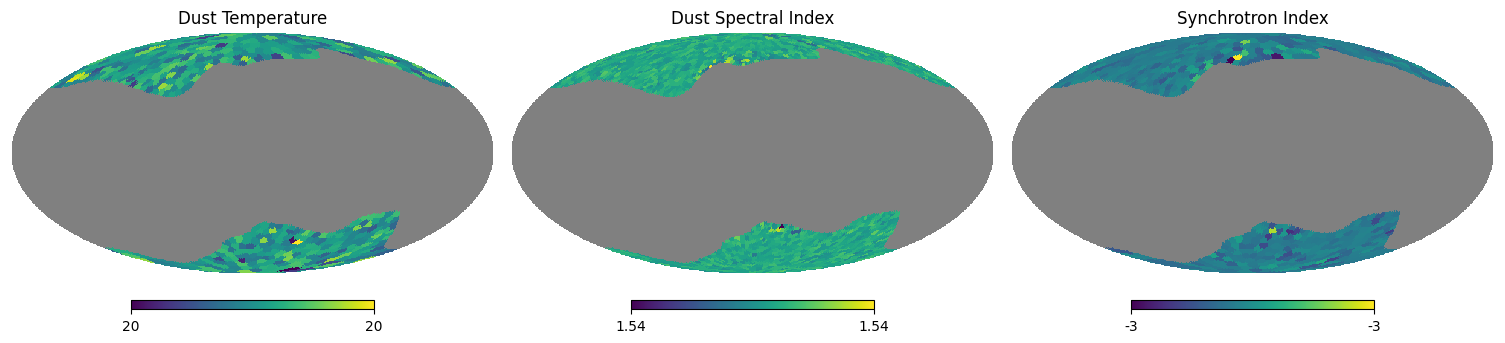

In [ ]:
# Results Visualization
fig = plt.figure(figsize=(15, 5))

# Plot the three parameter maps only
hp.mollview(param_maps["temp_dust"], title="Dust Temperature", sub=(1, 3, 1), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_dust"], title="Dust Spectral Index", sub=(1, 3, 2), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_pl"], title="Synchrotron Index", sub=(1, 3, 3), bgcolor=(0.0,) * 4)

plt.tight_layout()
plt.show()

Computing NLLs and Gradients for multiple scales...
  Processing scale: 1.0e-03
  Processing scale: 1.0e-04


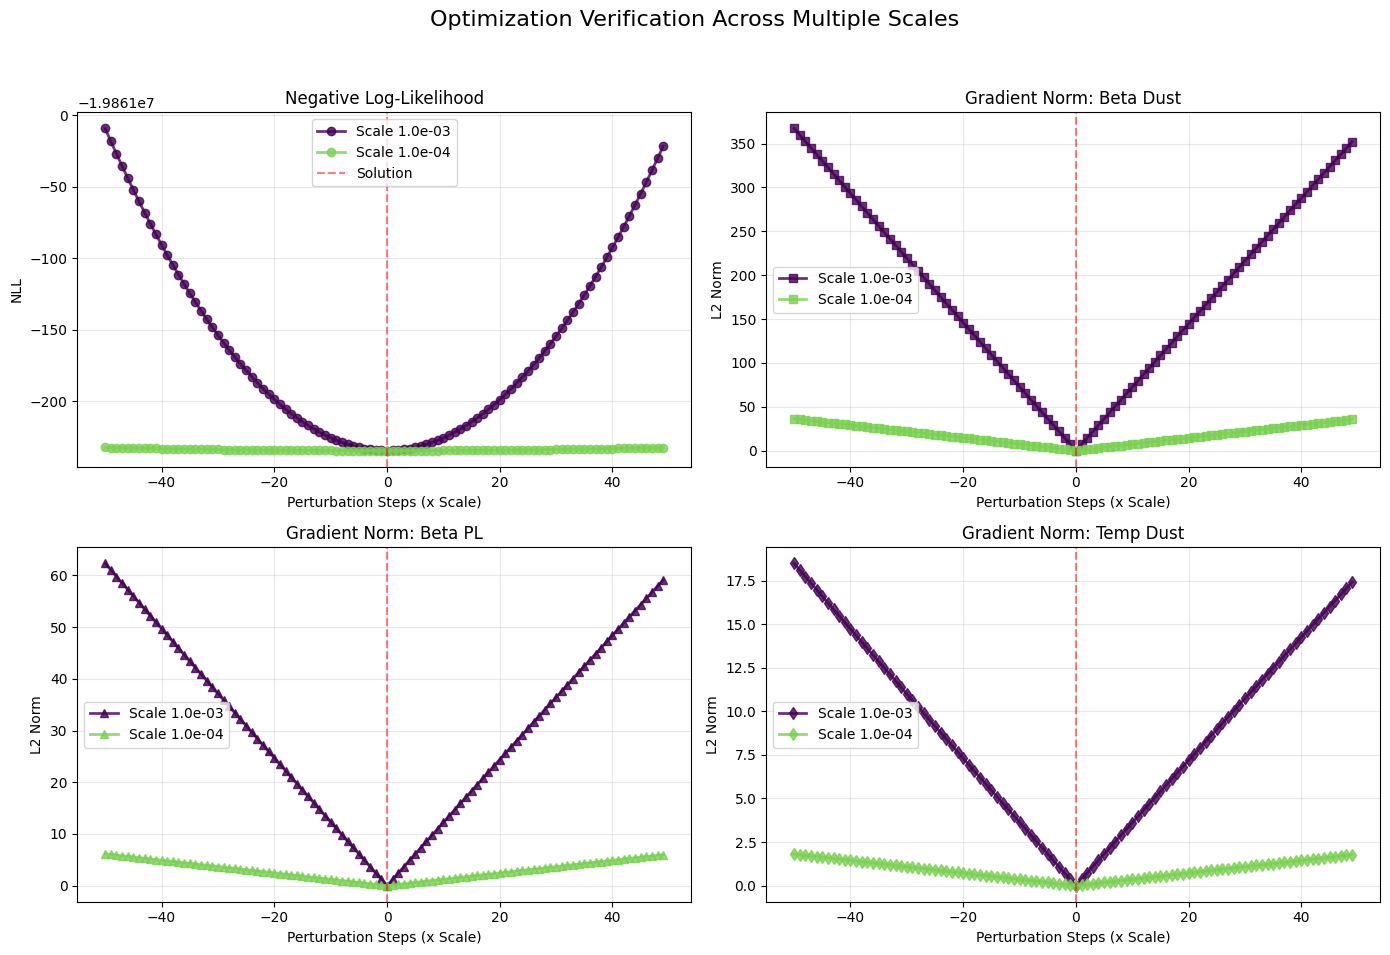

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# 1. Define Multiple Scales
scales = [1e-3, 1e-4]  # You can add more scales here
points = 100
steps = jnp.arange(-points // 2, points // 2)


# 2. Define JIT-compiled functions (compiled once)
@jax.jit
def grad_nll(params):
    return jax.grad(negative_log_likelihood_fn)(
        params,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_clusters,
    )


@jax.jit
def eval_nll(params):
    return negative_log_likelihood_fn(
        params,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_clusters,
    )


# 3. Setup Plotting Grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Optimization Verification Across Multiple Scales", fontsize=16)

# Colors for different scales
colors = plt.cm.viridis(jnp.linspace(0, 0.8, len(scales)))

print("Computing NLLs and Gradients for multiple scales...")

# 4. Loop over scales
for i, scale in enumerate(scales):
    print(f"  Processing scale: {scale:.1e}")

    # Calculate perturbations for this scale
    perturbations = steps.reshape(-1, 1) * scale

    # Perturb Parameters
    final_params_perturbed = jax.tree.map(lambda p: p.reshape(1, -1) + perturbations, final_params)

    # Compute Results
    nlls = jax.vmap(eval_nll)(final_params_perturbed)
    grads = jax.vmap(grad_nll)(final_params_perturbed)

    # Extract Norms
    grads_beta_dust_norm = jnp.linalg.norm(grads["beta_dust"], axis=1)
    grads_beta_pl_norm = jnp.linalg.norm(grads["beta_pl"], axis=1)
    grads_temp_dust_norm = jnp.linalg.norm(grads["temp_dust"], axis=1)

    # --- Plotting for this scale ---
    label = f"Scale {scale:.1e}"
    color = colors[i]

    # Plot 1: Negative Log Likelihood
    ax = axes[0, 0]
    ax.plot(steps, nlls, "o-", linewidth=2, color=color, label=label, alpha=0.8)

    # Plot 2: Gradient Norm - Beta Dust
    ax = axes[0, 1]
    ax.plot(steps, grads_beta_dust_norm, "s-", linewidth=2, color=color, label=label, alpha=0.8)

    # Plot 3: Gradient Norm - Beta PL
    ax = axes[1, 0]
    ax.plot(steps, grads_beta_pl_norm, "^-", linewidth=2, color=color, label=label, alpha=0.8)

    # Plot 4: Gradient Norm - Temp Dust
    ax = axes[1, 1]
    ax.plot(steps, grads_temp_dust_norm, "d-", linewidth=2, color=color, label=label, alpha=0.8)

# 5. Final Plot Formatting
# NLL Plot
ax = axes[0, 0]
ax.set_title("Negative Log-Likelihood")
ax.set_ylabel("NLL")
ax.set_xlabel("Perturbation Steps (x Scale)")
ax.grid(True, alpha=0.3)
ax.axvline(0, color="red", linestyle="--", alpha=0.5, label="Solution")
ax.legend()

# Beta Dust Grad Plot
ax = axes[0, 1]
ax.set_title("Gradient Norm: Beta Dust")
ax.set_ylabel("L2 Norm")
ax.set_xlabel("Perturbation Steps (x Scale)")
ax.grid(True, alpha=0.3)
ax.axvline(0, color="red", linestyle="--", alpha=0.5)
ax.legend()

# Beta PL Grad Plot
ax = axes[1, 0]
ax.set_title("Gradient Norm: Beta PL")
ax.set_ylabel("L2 Norm")
ax.set_xlabel("Perturbation Steps (x Scale)")
ax.grid(True, alpha=0.3)
ax.axvline(0, color="red", linestyle="--", alpha=0.5)
ax.legend()

# Temp Dust Grad Plot
ax = axes[1, 1]
ax.set_title("Gradient Norm: Temp Dust")
ax.set_ylabel("L2 Norm")
ax.set_xlabel("Perturbation Steps (x Scale)")
ax.grid(True, alpha=0.3)
ax.axvline(0, color="red", linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()